# Genetické programování

Dneska si vyzkoušíme genetické programování na problému symbolické regrese (tj. nalezení vzorečku, který odpovídá zadaným datům) a klasifikace, tj. hledání rozhodovacího stromu pomocí genetického programování. Budeme používat knihovnu deap, kterou jsme si ukázali minule.

Začneme importy a vygenerujeme si data, která pro regresi použijeme.

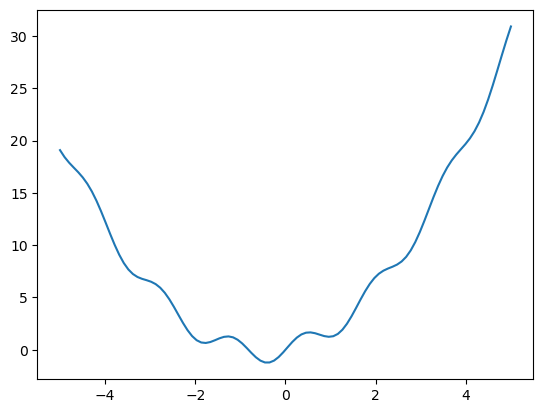

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.plot(x_train, y_train)
plt.show()

Připravíme si ještě pomocnou funkci na zobrazení vytvořeného stromu. Ta používa knihovnu pydot (a program GraphViz) pro kreslení grafů.
Instalace GraphVizu může být zvlášť na Windowsech problematická, doporučuju použít pro instalaci nástroj `conda` (takový lepší `pip`), anebo si tento jupyter notebook nahrát do [Colabu](colab.research.google.com/)


In [12]:
import pydot
from IPython.display import Image

# display the individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

Při práci s genetickým programováním musíme vytvořit množinu primitiv - terminály a neterminály - se kterými se v evoluci bude pracovat. Na to použijte třídu `gp.PrimitiveSet` v `deap`u, anebo `gp.PrimitiveSetTyped` pro typované GP. Ukážeme variantu s typy, neboť je obecnější (ale použijeme jen typ float, takže ji úplně nepotřebujeme).

In [13]:
import operator

from deap import gp

pset = gp.PrimitiveSetTyped('MAIN', [float], float) # the name of the set is MAIN, there is one float input and one float output
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

In [14]:
from deap import creator, base, tools, algorithms

#define fitness - it computes the MSE and individual size, the weights are set below to (-1.0 a -0.01)
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # compile can be used to transform the individual into a function callable in Python
    vals = list(map(func, x))
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#set up the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#limit the depth of the tree
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

/home/suchopag/miniconda3/envs/inspi/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/suchopag/miniconda3/envs/inspi/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
pop = toolbox.population(n=100)
#save the best solution
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min  	nevals	std    	avg  	gen	max	min	nevals	std    
0  	100   	375.099	0  	20836.5	10.57	100   	2067.51	70.27	0  	507	5  	100   	106.826
1  	57    	124.583	1  	1825.78	7.03293	57    	172.284	41.73	1  	507	2  	57    	80.3943
2  	50    	96.1202	2  	138.66 	7.03293	50    	24.86  	23.7 	2  	177	5  	50    	25.9151
3  	46    	82.3889	3  	163.156	7.03293	46    	29.7456	20.18	3  	95 	5  	46    	12.22  
4  	51    	70.0277	4  	188.697	7.03293	51    	35.597 	18.95	4  	68 	3  	51    	8.23089
5  	56    	59.7486	5  	133.398	7.03293	56    	40.4961	17.89	5  	35 	4  	56    	5.57117
6  	42    	38.273 	6  	456.75 	7.03293	42    	53.9028	17.28	6  	35 	3  	42    	5.44625
7  	51    	33.8732	7  	460.313	7.03293	51    	58.8695	15.28	7  	36 	3  	51    	6.30568
8  	52 

Nakreslíme si nejlepšího jedince:

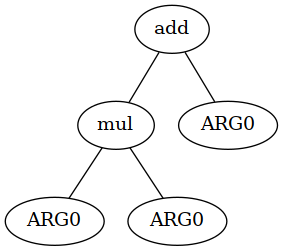

In [6]:
Image(plot_tree(hof[0]))

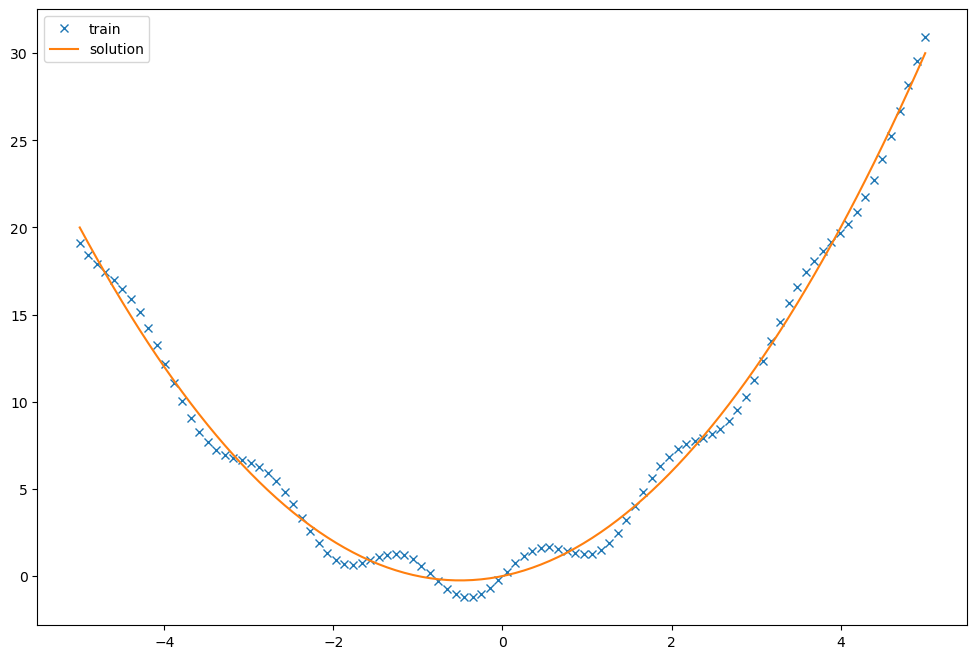

In [16]:
# compare the function we found with the training data
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'x', label='train')
plt.plot(x_train, y, label='solution')
plt.legend()
plt.show()

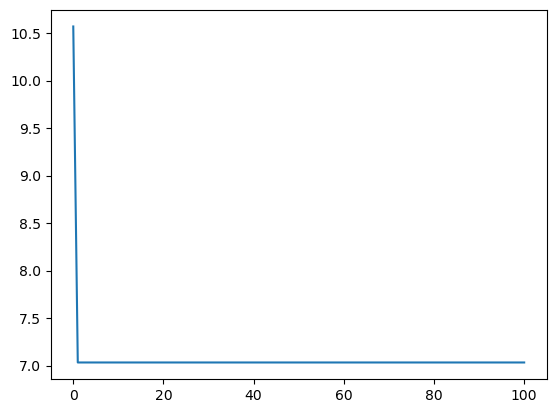

In [17]:
plt.plot([l['min'] for l in log.chapters['fitness']])

## Cvičení

Použijte GP na vyřešení klasifikačního problému (např. irisy) - vytvořte rozhodovací strom. Zkuste vymyslet, jak navrhnout množinu primitiv a fitness. Pak algoritmus spusťte jako předtím.

Jiné datasety naleznete zde: https://scikit-learn.org/stable/datasets/toy_dataset.html

In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y= load_iris(return_X_y=True)

seed = 41
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=seed)
xtrain.shape, xtest.shape

((112, 4), (38, 4))